### Парсинг на Python:

Для начала я хочу написать, что я всего лишь 2 раза занимался такой штукой и сейчас решил изучить ее поподробнее. Для начала научусь работать с библиотекой BeatifulSoup и сделаю небольшую систему оповещений и она будет состоять из следующих тасков, которые будут обернуты в dag:
1. Паршу вакансии(практически закончил разобраться почему порой он берет значения не от туда, а также стоило бы добавить описание, чтобы сообщения отправлялись с пользой); +
2. Загружаю значения в бд; +
3. Беру только новые значения, а то есть left-only join; +
4. Отправляю все новые значения в телеграм канал каждый месяц. +

##### To-Do list:
1. Разобраться с выводом description, subway; +
2. Оптимизировать парсер; +
3. Подобрать оптимальные фильтры и написать таск; +
4. Создать таск с ботом с отправкой сообщения. +
5. Подумать над оптимизацией проекта, плюс подумать на счет бд и airflow.

In [217]:
import pandas as pd
import seaborn as sns
import requests
from hyper.contrib import HTTP20Adapter
from bs4 import BeautifulSoup as bs
from time import sleep
from airflow.decorators import dag, task
from datetime import datetime, timedelta
from clickhouse_driver import Client
import telegram

sns.set(rc={'figure.figsize': (12, 8)})

Сначала укажу все дефолтные параметры:

In [12]:
default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=3),
    'start_date': datetime(2022, 9, 3),
}

In [13]:
client = Client(host='localhost')

In [14]:
my_token = "5711117341:AAEiU75eEX5RTbMEncnGh32JwsnhTSHtDrM"
bot = telegram.Bot(token=my_token)

In [15]:
updates = bot.getUpdates()
print(updates)

[]


In [16]:
chat_id = -1001786025908

In [17]:
schedule_interval = "00 22 * * 7"

Парсить я буду квартиры в Москве с сайта авито, далее я хочу поисследовать данные и сделать какие-то выводы.

Что буду парсить:
1. Ссылку;
2. Цену за квадратный метр;
3. Стоимость за квадратный метр;
4. Стоимость квартиры;
5. Расстояние от метро.

In [18]:
lst_links = []
lst_square = []
lst_price = []
lst_subway = []
lst_description = []
lst_minutes = []

In [ ]:
def parce_vacancies():
    #Сначала создаем цикл, где будем идти по страницам:
    for page in range(1, 99):
        print(page)  #чтобы отслеживать на какой страницы мы
        full_url = f"https://www.avito.ru/moskva/kvartiry/prodam-ASgBAgICAUSSA8YQ?cd=1&p={page}"
        source = requests.Session()
        source.mount('https://', HTTP20Adapter())
        response = source.get(full_url)
        sleep(7)  #чтобы не перегружался
        #инкодим значения иначе будет эльфийский
        response.encoding = 'utf-8'
        soup = bs(response.text, 'lxml')

        all_flats = soup.findAll("div", class_="iva-item-content-rejJg")

        #А здесь уже большой цикл обработки, где будем идти и собирать данные с каждой квартиры:
        for flat in all_flats:

            #Ссылка на квартиру:
            var_link = flat.find("a",
                                 "link-link-MbQDP link-design-default-_nSbv title-root-zZCwT iva-item-title-py3i_ title-listRedesign-_rejR title-root_maxHeight-X6PsH")
            if type(var_link) != type(None):
                local_var_link = "https://www.avito.ru" + var_link.get("href")
                lst_links.append([local_var_link])
            else:
                lst_links.append([None])

            #Отбираем цену за квадрат:
            var_square = flat.find("span",
                                   class_="price-noaccent-X6dOy price-normalizedPrice-PplY9 text-text-LurtD text-size-s-BxGpL")
            if type(var_square) != type(None):
                var = flat.find("span",
                                class_="price-noaccent-X6dOy price-normalizedPrice-PplY9 text-text-LurtD text-size-s-BxGpL").text
                correct_number_square_price = ""
                #Очищаем строку от бесполезного мусора:
                for var_square_circle in var:
                    if var_square_circle.isdigit():
                        correct_number_square_price += var_square_circle
                #Убираем последнею цифру, там значение в квадрате:
                correct_number_square_price = correct_number_square_price.replace(correct_number_square_price[-1], "")
                lst_square.append(correct_number_square_price)
            else:
                lst_square.append(None)

            #Отбираем полную цену:
            var_full_price = flat.find("span", class_="price-text-_YGDY text-text-LurtD text-size-s-BxGpL")
            if type(var_full_price) != type(None):
                full_price = var_full_price.text
                correct_number_full_price = ""
                #Оставляем лишь число:
                for var_full_price_circle in full_price:
                    if var_full_price_circle.isdigit():
                        correct_number_full_price += var_full_price_circle

                lst_price.append(correct_number_full_price)
            else:
                lst_price.append(None)

            #Отбираем станцию метро:
            var_subway = flat.find('div', class_="geo-georeferences-SEtee text-text-LurtD text-size-s-BxGpL")
            if type(var_subway) != type(None):
                subway_name = var_subway.text
                subway_full = ""
                for var_subway_circle in subway_name:
                    if var_subway_circle.isalpha() or var_subway_circle == " " or var_subway_circle == "-":
                        subway_full += var_subway_circle
                    else:  #после станции идет время сколько от метро и это значение число, тем самым убираем его
                        break
                #Прописываю if для тех случаев когда в название метро попадает от и до:
                if (subway_full[-1] == "т" and subway_full[-2] == "о") or (
                        subway_full[-1] == "о" and subway_full[-2] == "д"):
                    subway_full = subway_full[0:-2]
                lst_subway.append(subway_full)
            else:
                lst_subway.append(None)

            #Добавляю расстояние от метро:
            var_minutes = flat.find("span", class_="geo-periodSection-bQIE4")
            if type(var_minutes) != type(None):
                var_minutes_text = var_minutes.text
                var_minutes_full = ""
                for var_minute_circle in var_minutes_text:
                    if var_minute_circle == '–' or var_minute_circle.isdigit():
                        var_minutes_full += var_minute_circle
                lst_minutes.append(var_minutes_full)
            else:
                lst_minutes.append(None)

    #Создаем датафрейм:
    full_df = pd.DataFrame(
        data={"square_price": lst_square, "full_price": lst_price, "subway": lst_subway, "links": lst_links,
              'destination_from_nearest_subway': lst_minutes})

    return full_df

In [ ]:
full_df = parce_vacancies()

In [ ]:
full_df_test = full_df.copy()

### Часть фильтра и отправки в тг:

In [207]:
full_df_test = pd.read_csv("flats_25_09_2022.csv")

In [209]:
def filter_df(df):
    df = df.drop_duplicates(
        subset="links")  #порой попадаются дубликаты так как сайт 'динамически' переходит на следующею страницу
    df.dropna(inplace=True)
    df[["square_price", "full_price"]] = df[["square_price", "full_price"]].astype("int64")
    df[["subway", "links", "destination_from_nearest_subway"]] = df[
        ["subway", "links", "destination_from_nearest_subway"]].astype(str)
    df.links = df.links.str.replace("[", "")  # неправильно конвертнулся тип при сохранение данных в csv
    df.links = df.links.str.replace("]", "")  # неправильно конвертнулся тип при сохранение данных в csv
    #full_df_test["links"] = full_df_test["links"].apply(lambda x: x[0])
    df.drop("Unnamed: 0", axis=1, inplace=True)

    df["quantity_of_metres"] = (df["full_price"] / df["square_price"]).round()
    return df

In [210]:
full_df_test = filter_df(full_df_test)

/home/onixx/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311 SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/onixx/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641 SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4866/493970709.py:7 FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/home/onixx/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516 SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4866/493970709.py:8 FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/home/onixx/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906 SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4866/493970709.py:12 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [211]:
def cheap_flats(df):
    def q10(x):
        return x.quantile(0.15)

    #Создаю датафрейм по каждой станции с 10 персентилем по каждой метрике
    metro_10_percentile = df.groupby("subway", as_index=False).agg({"full_price": q10, "square_price": q10}).rename(
        columns={"full_price": "full_price_10_percentile", "square_price": "square_price_10_percentile"}).sort_values(
        "square_price_10_percentile", ascending=False)

    needed_flats = df.query("destination_from_nearest_subway in ('5','6-10')")
    both_frames = needed_flats.merge(metro_10_percentile, how="left", on="subway")
    cheep_flats = both_frames.query(
        "square_price <= square_price_10_percentile and full_price <= full_price_10_percentile").drop_duplicates(
        subset="links")
    cheep_flats = cheep_flats[
        ["square_price", "full_price", "subway", "links", "destination_from_nearest_subway", "quantity_of_metres"]]

    return cheep_flats

In [213]:
needed_df = cheap_flats(full_df_test)

In [215]:
def send_cheap_flats(df):
    for index, row in df.iterrows():
        sleep(7)
        current_row = f"На сайте появилась выгодная квартира, цена за квадратный метр следующая {row[0]}, полная цена = {row[1]}, кол-во квадратных метров = {row[5]} и находиться данная квартира на следующей станции метро = {row[2]} ({row[4]} минуток от метро). Если вас заинтересовало данное предложение переходите по ссылке: {row[3]}"
        bot.sendMessage(chat_id=chat_id, text=current_row)

In [216]:
send_cheap_flats(needed_df)

Создал sql запрос на создание таблички:

In [118]:
query = """
CREATE TABLE default.flats_test(
    square_price Int64,
    full_price Int64,
    subway String,
    links String,
    destination_from_nearest_subway String,
    quantity_of_metres Float64
    )
ENGINE = MergeTree
Order by links
"""

Теперь создам таск небольшой пред обработкой:

In [119]:
full_df_test.isna().sum()

Unnamed: 0                           0
square_price                        65
full_price                           0
subway                              40
links                                0
destination_from_nearest_subway    111
dtype: int64

Создам таск, в котором, буду отбирать только новые значения:

In [130]:
def uncommon_values(df_new):
    #Достаем все записи из таблицы и создаем новый датафрейм:
    df_old = client.execute("Select * from vacancies")
    df_old = pd.DataFrame(columns=["square_price", "full_price", "subway", "links", "destination_from_nearest_subway"],
                          data=df_old)

    df = df_new.merge(df_old, on='id', how='left', indicator=True)
    df.drop(["name_surname_y", "country_y", "company_name_y", "position_y"], axis=1, inplace=True)
    df.rename(columns={"name_surname_x": "name_surname", "country_x": "country", "company_name_x": "company_name",
                       "position_x": "position"}, inplace=True)
    df = df.loc[df["_merge"] == 'left_only']
    df.drop(["_merge"], axis=1, inplace=True)
    return df

In [131]:
uncommon_values(full_df_test)

Создам таск с добавлением новых записей в бд:

In [132]:
def to_clickhouse(df):
    client.execute("INSERT INTO default.vacancies VALUES", df.to_dict(orient="records"))
    client.execute('OPTIMIZE TABLE vacancies DEDUPLICATE BY links')

In [133]:
#to_clickhouse(full_df_test)

Теперь я хочу немного поисследовать данные:

In [134]:
full_df_test.subway.unique().shape[0]

240

In [135]:
quantity_full_price_df = full_df_test.groupby("subway", as_index=False).agg(
    {"full_price": "sum", "links": "count"}).rename(
    columns={"full_price": "price_for_per_flats", "links": "quantity_of_flats"}).sort_values("price_for_per_flats",
                                                                                             ascending=False)

In [136]:
quantity_full_price_df.head()

,subway,price_for_per_flats,quantity_of_flats
139,Парк культуры,5707306493,18
105,Международная,4937729300,69
103,Маяковская,3916646156,43
107,Минская,3818719000,41
81,Кропоткинская,2527473900,16


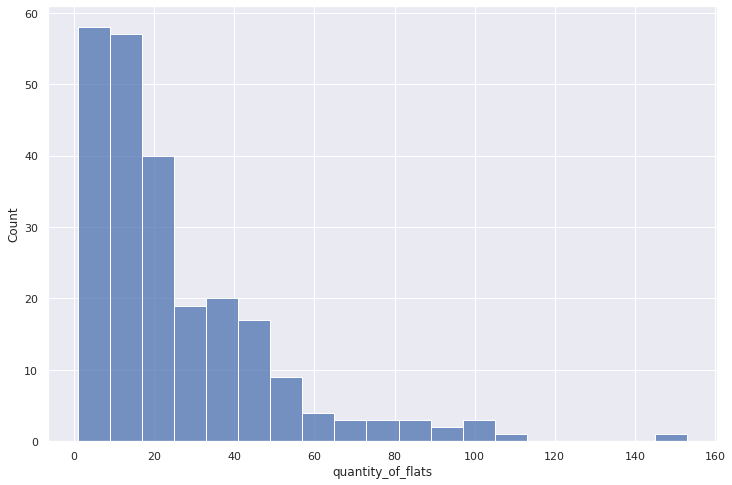

In [137]:
sns.histplot(quantity_full_price_df.quantity_of_flats);

In [138]:
full_df_test.full_price.quantile([0.25, 0.5, 0.75, 0.95])

0.25     6600000.0
0.50    11400000.0
0.75    18000000.0
0.95    63000000.0
Name: full_price, dtype: float64

In [139]:
full_df_test.destination_from_nearest_subway.value_counts()

6–10     1653
11–15    1607
16–20     789
21–30     743
5         629
31        528
Name: destination_from_nearest_subway, dtype: int64

In [140]:
full_df_test.square_price.quantile([0.25, 0.5, 0.75, 0.95])

0.25    211905.0
0.50    267050.0
0.75    345794.0
0.95    582353.0
Name: square_price, dtype: float64

По сути хорошей идеей будет сравнивать квартиры ниже 10 персентиля:

In [141]:
def q10(x):
    return x.quantile(0.10)

In [142]:
metro_10_percentile = full_df_test.groupby("subway", as_index=False).agg(
    {"full_price": q10, "square_price": q10}).rename(
    columns={"full_price": "full_price_10_percentile", "square_price": "square_price_10_percentile"}).sort_values(
    "square_price_10_percentile", ascending=False)

metro_10_percentile.head()

,subway,full_price_10_percentile,square_price_10_percentile
51,Добрынинская,58100000.0,867164.0
193,Театральная,93459234.0,728275.2
135,Охотный ряд,94136336.0,722975.0
48,Деловой центр,33000000.0,660000.0
122,Новокузнецкая,28000000.0,643678.0


In [143]:
full_df_test["quantity_of_metres"] = (full_df_test["full_price"] / full_df_test["square_price"]).round()

In [144]:
full_df_test.head()

,square_price,full_price,subway,links,destination_from_nearest_subway,quantity_of_metres
0,266055,8700000,Домодедовская,'https://www.avito.ru/moskva/kvartiry/1-k._kva...,21–30,33.0
1,232500,4650000,Жулебино,'https://www.avito.ru/moskva/kvartiry/kvartira...,11–15,20.0
2,216981,11500000,Бабушкинская,'https://www.avito.ru/moskva/kvartiry/2-k._kva...,31,53.0
3,370000,7585000,Аэропорт,'https://www.avito.ru/moskva/kvartiry/1-k._kva...,11–15,20.0
4,307008,11727705,Бутырская,'https://www.avito.ru/moskva/kvartiry/1-k._kva...,6–10,38.0


При этом стоит также подумать над расстоянием от метро, как по мне раз мы ищем самые выгодные, то нужно сделать следующее:

1. Брать только те станции, где расстояние 5 или 6-10;
2. Брать если цена за квадратный метр и цена относительно метро меньше 10 персентиля.

In [145]:
needed_flats = full_df_test.query("destination_from_nearest_subway in ('5','6-10')")
needed_flats.head()

,square_price,full_price,subway,links,destination_from_nearest_subway,quantity_of_metres
10,572246,80000000,Кутузовская,'https://www.avito.ru/moskva/kvartiry/3-k._kva...,5,140.0
17,94752,6500000,Спартак,'https://www.avito.ru/moskva/kvartiry/3-k._kva...,5,69.0
28,237500,4750000,Боровское шоссе,'https://www.avito.ru/moskva/kvartiry/kvartira...,5,20.0
44,708955,95000000,Сокольники,'https://www.avito.ru/moskva/kvartiry/4-k._kva...,5,134.0
50,114933,4310000,Шипиловская,'https://www.avito.ru/moskva/kvartiry/1-k._kva...,5,38.0


In [146]:
both_frames = needed_flats.merge(metro_10_percentile, how="left", on="subway")
both_frames.head()

,square_price,full_price,subway,links,destination_from_nearest_subway,quantity_of_metres,full_price_10_percentile,square_price_10_percentile
0,572246,80000000,Кутузовская,'https://www.avito.ru/moskva/kvartiry/3-k._kva...,5,140.0,5120000.0,336896.8
1,94752,6500000,Спартак,'https://www.avito.ru/moskva/kvartiry/3-k._kva...,5,69.0,6500000.0,94752.0
2,237500,4750000,Боровское шоссе,'https://www.avito.ru/moskva/kvartiry/kvartira...,5,20.0,4620000.0,221772.6
3,708955,95000000,Сокольники,'https://www.avito.ru/moskva/kvartiry/4-k._kva...,5,134.0,13700000.0,26182.0
4,114933,4310000,Шипиловская,'https://www.avito.ru/moskva/kvartiry/1-k._kva...,5,38.0,4310000.0,114933.0


In [170]:
cheep_flats = both_frames.query(
    "square_price <= square_price_10_percentile and full_price <= full_price_10_percentile").drop_duplicates()
cheep_flats.head()

,square_price,full_price,subway,links,destination_from_nearest_subway,quantity_of_metres,full_price_10_percentile,square_price_10_percentile
1,94752,6500000,Спартак,'https://www.avito.ru/moskva/kvartiry/3-k._kva...,5,69.0,6500000.0,94752.0
4,114933,4310000,Шипиловская,'https://www.avito.ru/moskva/kvartiry/1-k._kva...,5,38.0,4310000.0,114933.0
10,117886,4350000,Пятницкое шоссе,'https://www.avito.ru/moskva/kvartiry/kvartira...,5,37.0,4542982.7,128863.8
34,175000,3150000,Бунинская аллея,'https://www.avito.ru/moskva/kvartiry/apartame...,5,18.0,5650000.0,183637.3
79,161811,3932000,Белорусская,'https://www.avito.ru/moskva/kvartiry/1-k._kva...,5,24.0,3932000.0,214863.0


In [171]:
cheep_flats = cheep_flats[
    ["square_price", "full_price", "subway", "links", "destination_from_nearest_subway", "quantity_of_metres"]]
cheep_flats.head()

,square_price,full_price,subway,links,destination_from_nearest_subway,quantity_of_metres
1,94752,6500000,Спартак,'https://www.avito.ru/moskva/kvartiry/3-k._kva...,5,69.0
4,114933,4310000,Шипиловская,'https://www.avito.ru/moskva/kvartiry/1-k._kva...,5,38.0
10,117886,4350000,Пятницкое шоссе,'https://www.avito.ru/moskva/kvartiry/kvartira...,5,37.0
34,175000,3150000,Бунинская аллея,'https://www.avito.ru/moskva/kvartiry/apartame...,5,18.0
79,161811,3932000,Белорусская,'https://www.avito.ru/moskva/kvartiry/1-k._kva...,5,24.0


In [175]:
for index, row in cheep_flats.iterrows():
    sleep(7)
    current_row = f"На сайте появилась выгодная квартира, цена за квадратный метр следующая {row[0]}, полная цена = {row[1]}, кол-во квадратных метров = {row[5]} и находиться данная квартира на следующей станции метро = {row[2]} ({row[4]} минуток от метро). Если вас заинтересовало данное предложение переходите по ссылке: {row[3]}"
    bot.sendMessage(chat_id=chat_id, text=current_row)

Все работает, а теперь стоит обернуть все действия в таски и построить Dag, а также отформатировать наш код под pep8:

In [ ]:
@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def cheap_flats():
    @task
    def parce_flats():
        #Сначала создаем цикл, где будем идти по страницам:
        for page in range(1, 99):
            print(page)  #чтобы отслеживать на какой страницы мы
            full_url = f"https://www.avito.ru/moskva/kvartiry/prodam-ASgBAgICAUSSA8YQ?cd=1&p={page}"
            source = requests.Session()
            source.mount('https://', HTTP20Adapter())
            response = source.get(full_url)
            sleep(7)  #чтобы не перегружался
            #инкодим значения иначе будет эльфийский
            response.encoding = 'utf-8'
            soup = bs(response.text, 'lxml')

            all_flats = soup.findAll("div", class_="iva-item-content-rejJg")

            #А здесь уже большой цикл обработки, где будем идти и собирать данные с каждой квартиры:
            for flat in all_flats:

                #Ссылка на квартиру:
                var_link = flat.find("a",
                                     "link-link-MbQDP link-design-default-_nSbv title-root-zZCwT iva-item-title-py3i_ title-listRedesign-_rejR title-root_maxHeight-X6PsH")
                if type(var_link) != type(None):
                    local_var_link = "https://www.avito.ru" + var_link.get("href")
                    lst_links.append([local_var_link])
                else:
                    lst_links.append([None])

                #Отбираем цену за квадрат:
                var_square = flat.find("span",
                                       class_="price-noaccent-X6dOy price-normalizedPrice-PplY9 text-text-LurtD text-size-s-BxGpL")
                if type(var_square) != type(None):
                    var = flat.find("span",
                                    class_="price-noaccent-X6dOy price-normalizedPrice-PplY9 text-text-LurtD text-size-s-BxGpL").text
                    correct_number_square_price = ""
                    #Очищаем строку от бесполезного мусора:
                    for var_square_circle in var:
                        if var_square_circle.isdigit():
                            correct_number_square_price += var_square_circle
                    #Убираем последнею цифру, там значение в квадрате:
                    correct_number_square_price = correct_number_square_price.replace(correct_number_square_price[-1],
                                                                                      "")
                    lst_square.append(correct_number_square_price)
                else:
                    lst_square.append(None)

                #Отбираем полную цену:
                var_full_price = flat.find("span", class_="price-text-_YGDY text-text-LurtD text-size-s-BxGpL")
                if type(var_full_price) != type(None):
                    full_price = var_full_price.text
                    correct_number_full_price = ""
                    #Оставляем лишь число:
                    for var_full_price_circle in full_price:
                        if var_full_price_circle.isdigit():
                            correct_number_full_price += var_full_price_circle

                    lst_price.append(correct_number_full_price)
                else:
                    lst_price.append(None)

                #Отбираем станцию метро:
                var_subway = flat.find('div', class_="geo-georeferences-SEtee text-text-LurtD text-size-s-BxGpL")
                if type(var_subway) != type(None):
                    subway_name = var_subway.text
                    subway_full = ""
                    for var_subway_circle in subway_name:
                        if var_subway_circle.isalpha() or var_subway_circle == " " or var_subway_circle == "-":
                            subway_full += var_subway_circle
                        else:  #после станции идет время сколько от метро и это значение число, тем самым убираем его
                            break
                    #Прописываю if для тех случаев когда в название метро попадает от и до:
                    if (subway_full[-1] == "т" and subway_full[-2] == "о") or (
                            subway_full[-1] == "о" and subway_full[-2] == "д"):
                        subway_full = subway_full[0:-2]
                    lst_subway.append(subway_full)
                else:
                    lst_subway.append(None)

                #Добавляю расстояние от метро:
                var_minutes = flat.find("span", class_="geo-periodSection-bQIE4")
                if type(var_minutes) != type(None):
                    var_minutes_text = var_minutes.text
                    var_minutes_full = ""
                    for var_minute_circle in var_minutes_text:
                        if var_minute_circle == '–' or var_minute_circle.isdigit():
                            var_minutes_full += var_minute_circle
                    lst_minutes.append(var_minutes_full)
                else:
                    lst_minutes.append(None)

        #Создаем датафрейм:
        full_df = pd.DataFrame(
            data={"square_price": lst_square, "full_price": lst_price, "subway": lst_subway, "links": lst_links,
                  'destination_from_nearest_subway': lst_minutes})

        return full_df

    @task
    def filter_df(df):

        df = df.drop_duplicates(
            subset="links")  #порой попадаются дубликаты так как сайт 'динамически' переходит на следующею страницу
        df.dropna(inplace=True)
        df[["square_price", "full_price"]] = df[["square_price", "full_price"]].astype("int64")
        df[["subway", "links", "destination_from_nearest_subway"]] = df[
            ["subway", "links", "destination_from_nearest_subway"]].astype(str)
        full_df_test["links"] = full_df_test["links"].apply(lambda x: x[0])
        df["quantity_of_metres"] = (df["full_price"] / df["square_price"]).round()

        return df

    @task
    def cheap_flats(df):

        def q10(x):
            return x.quantile(0.15)

        #Создаю датафрейм по каждой станции с 10 персентилем по каждой метрике
        metro_10_percentile = df.groupby("subway", as_index=False).agg({"full_price": q10, "square_price": q10}).rename(
            columns={"full_price": "full_price_10_percentile",
                     "square_price": "square_price_10_percentile"}).sort_values("square_price_10_percentile",
                                                                                ascending=False)

        needed_flats = df.query("destination_from_nearest_subway in ('5','6-10')")
        both_frames = needed_flats.merge(metro_10_percentile, how="left", on="subway")
        cheep_flats = both_frames.query(
            "square_price <= square_price_10_percentile and full_price <= full_price_10_percentile").drop_duplicates(
            subset="links")
        cheep_flats = cheep_flats[
            ["square_price", "full_price", "subway", "links", "destination_from_nearest_subway", "quantity_of_metres"]]

        return cheep_flats

    @task
    def uncommon_values(df_new):

        df_old = client.execute("Select * from vacancies")
        df_old = pd.DataFrame(
            columns=["square_price", "full_price", "subway", "links", "destination_from_nearest_subway",
                     "quantity_of_metres"], data=df_old)

        df = df_new.merge(df_old, on='id', how='left', indicator=True)
        df.drop(["name_surname_y", "country_y", "company_name_y", "position_y"], axis=1, inplace=True)
        df.rename(columns={"name_surname_x": "name_surname", "country_x": "country", "company_name_x": "company_name",
                           "position_x": "position"}, inplace=True)
        df = df.loc[df["_merge"] == 'left_only']
        df.drop(["_merge"], axis=1, inplace=True)
        return df

    @task
    def to_clickhouse(df):
        client.execute("INSERT INTO default.vacancies VALUES", df.to_dict(orient="records"))
        client.execute('OPTIMIZE TABLE vacancies DEDUPLICATE BY links')

    @task
    def send_cheap_flats(df):
        for index, row in df.iterrows():
            sleep(7)
            current_row = f"На сайте появилась выгодная квартира, цена за квадратный метр следующая {row[0]}, полная цена = {row[1]}, кол-во квадратных метров = {row[5]} и находиться данная квартира на следующей станции метро = {row[2]} ({row[4]} минуток от метро). Если вас заинтересовало данное предложение переходите по ссылке: {row[3]}"
            bot.sendMessage(chat_id=chat_id, text=current_row)

    new_flats = parce_flats()
    new_flats_filtered = filter_df(new_flats)
    cheap_flats_filtered = cheap_flats(new_flats_filtered)
    new_cheap_flats = uncommon_values(cheap_flats_filtered)
    to_clickhouse(new_cheap_flats)
    send_cheap_flats(new_cheap_flats)


cheap_flats = cheap_flats()